In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, accuracy_score
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [2]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [3]:
print("Loading the imputed PhysioNet Heart Failure dataset...")
df = pd.read_csv('imputed_original.csv')
print(f"Dataset shape: {df.shape}")

Loading the imputed PhysioNet Heart Failure dataset...
Dataset shape: (2008, 40)


In [4]:
df.head()

,verbal.response,eye.opening,movement,GCS,lactate.dehydrogenase,glutamic.oxaloacetic.transaminase,globulin,total.bilirubin,direct.bilirubin,indirect.bilirubin,...,eosinophil.ratio,eosinophil.count,basophil.ratio,basophil.count,creatinine.enzymatic.method,cystatin,sodium,chloride,systolic.blood.pressure,re.admission.within.6.months
0,5,4,6,15,294.000000,81.000000,23.8,18.3,6.9,11.4,...,0.002,0.02,0.006,0.05,108.3,1.32,134.6,101.9,102,0
1,5,4,6,15,203.000000,21.000000,25.4,18.3,5.2,13.1,...,0.009,0.05,0.002,0.01,62.0,1.25,144.0,105.6,150,0
2,5,4,6,15,137.000000,9.000000,27.7,11.9,4.4,7.5,...,0.002,0.02,0.002,0.03,185.1,2.43,142.2,107.0,102,0
3,5,4,6,15,440.404449,252.839996,27.0,51.6,25.4,26.2,...,0.028,0.06,0.000,0.00,104.8,2.32,136.3,101.6,110,1
4,5,4,6,15,295.000000,30.000000,29.6,11.8,4.9,6.9,...,0.008,0.05,0.002,0.01,83.9,1.35,136.6,104.3,134,0


In [5]:
target_col = 're.admission.within.6.months'
print(f"\nTarget variable distribution:")
print(df[target_col].value_counts())
print(f"Class imbalance ratio: 1:{df[target_col].value_counts()[0]/df[target_col].value_counts()[1]:.2f}")


Target variable distribution:
re.admission.within.6.months
0    1235
1     773
Name: count, dtype: int64
Class imbalance ratio: 1:1.60


In [6]:
# leakage_cols = [
#     # The following columns likely contain information related to our target
#     'return.to.emergency.department.within.6.months',  # Very similar to our target
#     're.admission.within.3.months',                   # Subset of our target
#     'death.within.3.months',                          # Potential leakage
#     'death.within.6.months',                          # Potential leakage
#     'death.within.28.days'                            # Potential leakage
# ]

In [7]:
X = df.drop(columns=[target_col])
y = df[target_col]

In [8]:
print(f"Features shape: {X.shape}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Features shape: (2008, 39)

Training set shape: (1606, 39)
Testing set shape: (402, 39)


In [9]:
# print(f"\nColumns to exclude due to potential data leakage: {leakage_cols}")

# # Remove the target and leakage columns
# X = df.drop(columns=[target_col] + leakage_cols)
# y = df[target_col]

In [10]:
# remaining_target_related = [col for col in X.columns if 'admission' in col.lower() or 'death' in col.lower()]
# if remaining_target_related:
#     print(f"\nWarning: Still found potential target-related columns: {remaining_target_related}")
#     X = X.drop(columns=remaining_target_related)
    
# print(f"Features shape after removing potential target leakage: {X.shape}")

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


Training set shape: (1606, 39)
Testing set shape: (402, 39)


In [12]:
print("\nApplying SMOTE to balance the training data...")
smote = SMOTE(random_state=RANDOM_STATE)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Original training class distribution: {pd.Series(y_train).value_counts().to_dict()}")
print(f"SMOTE-balanced training class distribution: {pd.Series(y_train_smote).value_counts().to_dict()}")


Applying SMOTE to balance the training data...
Original training class distribution: {0: 988, 1: 618}
SMOTE-balanced training class distribution: {0: 988, 1: 988}


In [13]:
print("\nTraining Random Forest classifier...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=RANDOM_STATE,
    n_jobs=-1
)


Training Random Forest classifier...


In [14]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [15]:
cv_scores = cross_val_score(rf_model, X_train_smote, y_train_smote, cv=kfold, scoring='f1')
print(f"Cross-validated F1 scores: {cv_scores}")
print(f"Mean CV F1 score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

Cross-validated F1 scores: [0.76020408 0.69346734 0.65927978 0.68947368 0.71212121]
Mean CV F1 score: 0.7029 (±0.0333)


In [16]:
rf_model.fit(X_train_smote, y_train_smote)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [17]:
print("\nEvaluating model on the test set...")
y_pred = rf_model.predict(X_test)


Evaluating model on the test set...


In [18]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.6020
Precision: 0.4766
Recall: 0.3290
F1 Score: 0.3893


In [19]:
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)


Confusion Matrix:
[[191  56]
 [104  51]]


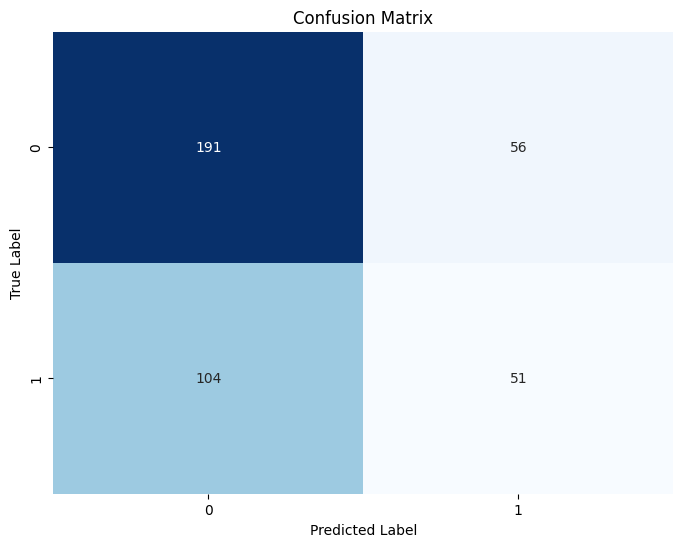

In [20]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [21]:
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))


Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.77      0.70       247
           1       0.48      0.33      0.39       155

    accuracy                           0.60       402
   macro avg       0.56      0.55      0.55       402
weighted avg       0.58      0.60      0.58       402



In [22]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 most important features:")
print(feature_importance.head(10))


Top 10 most important features:
                                Feature  Importance
34          creatinine.enzymatic.method    0.038581
36                               sodium    0.034215
19                 white.globulin.ratio    0.033907
35                             cystatin    0.033203
12                       red.blood.cell    0.033146
13                                  map    0.031094
11                           hematocrit    0.029746
27                     white.blood.cell    0.029701
18                         nucleotidase    0.029552
16  low.density.lipoprotein.cholesterol    0.029418


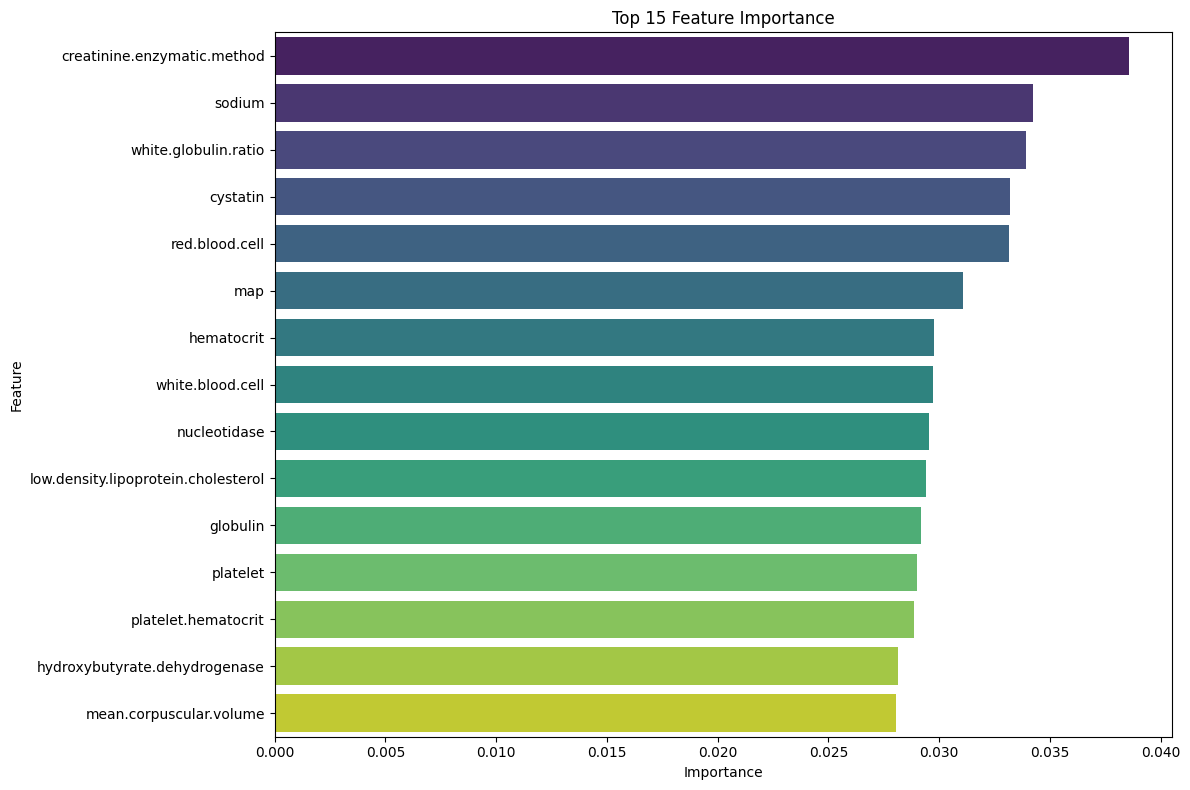

In [23]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15), palette='viridis')
plt.title('Top 15 Feature Importance')
plt.tight_layout()
plt.show()

In [ ]:
print("\nComparison with the paper's results:")
paper_f1_score = 0.4672

print(f"Paper's reported F1 score: {paper_f1_score:.4f}")
print(f"Our F1 score: {f1:.4f}")
print(f"Difference: {f1 - paper_f1_score:.4f}")

if abs(f1 - paper_f1_score) < 0.05:
    print("Your imputation method performs similarly to the I-NAA method from the paper,")
    print("which suggests the results are now in a realistic range after removing data leakage.")
elif f1 > paper_f1_score:
    print("Your imputation method appears to outperform the I-NAA method from the paper!")
else:
    print("Your imputation method performs slightly below the I-NAA method from the paper.")



Comparison with the paper's results:
Paper's reported F1 score: 0.4672
Our F1 score: 0.3893
Difference: -0.0779
Your imputation method performs slightly below the I-NAA method from the paper.


: 